In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generic imports
import matplotlib.pyplot as plt
import numpy as np
import glob, datetime, os

from tqdm.auto import tqdm

from astropy.wcs import WCS
from astropy.io import fits as fits

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

import astroscrappy

from esutil import htm

# Disable some annoying warnings from astropy
import warnings
from astropy.wcs import FITSFixedWarning
from astropy.io.fits.verify import VerifyWarning
warnings.simplefilter(action='ignore', category=FITSFixedWarning)
warnings.simplefilter(action='ignore', category=VerifyWarning)

# Our sub-modules
from stdpipe import astrometry, photometry, catalogs, cutouts, templates, subtraction, plots, pipeline, psf, utils

# Adjust default parameters for imshow
plt.rc('image', origin='lower', cmap='Blues_r')




# Injection of simulated stars into the image

## Load and calibrate original image

In [2]:
# KAIT image of 2018cow
filename = '../tests/2018cow_20180620_043017_Jun8keuq_kait_clear_c.fit'

header = fits.getheader(filename)
image = fits.getdata(filename).astype(np.double)

print('Processing %s: %d x %d' % (os.path.split(filename)[1], image.shape[1], image.shape[0]))

# Image gain, e/ADU
gain = header.get('GAIN', 1)

# Create mask of bad pixels
mask = image > 50000 # Rough saturation level

# Cosmics
cmask, cimage = astroscrappy.detect_cosmics(image, mask, verbose=False)
mask |= cmask
print('Done masking cosmics')

# Initial WCS
wcs = WCS(header)

# Extract objects
obj = photometry.get_objects_sextractor(image, mask=mask, r0=1, aper=5.0, wcs=wcs, gain=gain)
print(len(obj), 'objects found')

ra0,dec0,sr0 = astrometry.get_frame_center(wcs=wcs, width=image.shape[1], height=image.shape[0])
pixscale = astrometry.get_pixscale(wcs=wcs)

cat = catalogs.get_cat_vizier(ra0, dec0, sr0, 'ps1', filters={'rmag':'<19'})
print(len(cat), 'catalogue stars')

cat_col_mag = 'rmag'
cat_color_mag1 = 'gmag'
cat_color_mag2 = 'rmag'

# WCS refinement
wcs = pipeline.refine_astrometry(obj, cat, 5*pixscale, wcs=wcs, order=0, cat_col_mag=cat_col_mag, verbose=True)
if wcs is None or not wcs.is_celestial:
    print('WCS refinement failed')

# Update WCS info in the header
astrometry.clear_wcs(header, remove_comments=True, remove_underscored=True, remove_history=True)
header.update(wcs.to_header(relax=True))

# Photometric calibration
m = pipeline.calibrate_photometry(obj, cat, pixscale=pixscale, cat_col_mag=cat_col_mag, cat_col_mag1=cat_color_mag1, cat_col_mag2=cat_color_mag2, order=0, verbose=True)

zero_fn = m['zero_fn'] # Function to get the zero point as a function of position on the image

obj['mag_calib'] = obj['mag'] + zero_fn(obj['x'], obj['y'])

Processing 2018cow_20180620_043017_Jun8keuq_kait_clear_c.fit: 500 x 500
Done masking cosmics
40 objects found
51 catalogue stars
Astrometric refinement using 4.0 arcsec radius, photometric matching and astropy WCS fitting
Iteration 0: 17 matches, 0.2 arcsec rms
Iteration 1: 17 matches, 0.2 arcsec rms
Iteration 2: 17 matches, 0.2 arcsec rms
Performing photometric calibration of 40 objects vs 51 catalogue stars
Using 1.4 arcsec matching radius, rmag magnitude and spatial order 0
Using (gmag - rmag) color for color term
Photometric calibration finished successfully.
Color term is 0.18


Text(0.5, 1.0, 'Original image')

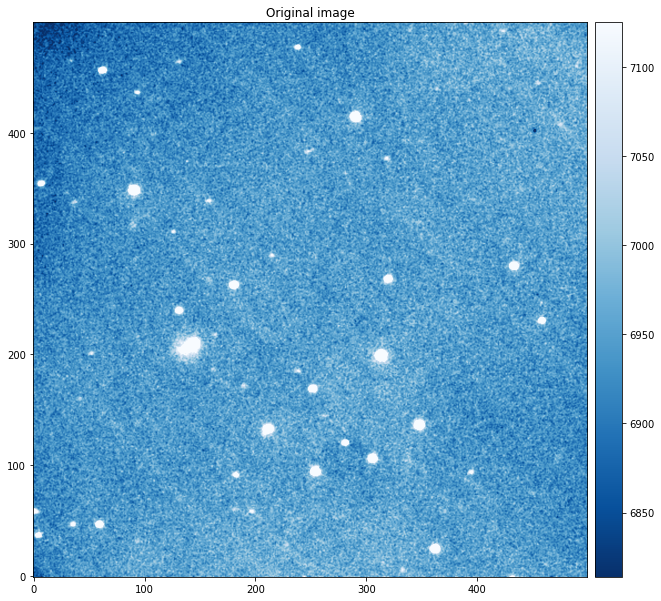

In [3]:
plots.imshow(image)
plt.title('Original image')

In [4]:
# We may roughly estimage the effective gain of the image from background mean and rms as gain = mean/rms**2
bg,rms = photometry.get_background(image, mask=mask, get_rms=True)

print('Effective gain is %.2f' % np.median(bg/rms**2))

Effective gain is 3.43


## Extract PSF model using PSFEx

Extracting PSF using vignette size 19 x 19 pixels
Will run SExtractor like that:
/opt/local/bin/sex /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexcttfa6nt/image.fits -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1 -DETECT_THRESH 2.0 -WEIGHT_TYPE BACKGROUND -MASK_TYPE NONE -FLAG_IMAGE /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexcttfa6nt/flags.fits -PHOT_APERTURES 6.0 -PARAMETERS_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexcttfa6nt/cfg.param -CATALOG_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexcttfa6nt/out.cat -CATALOG_TYPE FITS_LDAC -FILTER Y -FILTER_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexcttfa6nt/kernel.txt
SExtractor run succeeded
Will run PSFEx like that:
/opt/local/bin/psfex /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexcttfa6nt/out.cat -VERBOSE_TYPE QUIET -CHECKPLOT_TYPE NONE -CHECKIMAGE_TYPE SNAPSHOTS -PSFVAR_DEGREES 0 -WRITE_XML N -CHECKIMAGE_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexcttfa6

Text(0.5, 1.0, 'PSF snapshots')

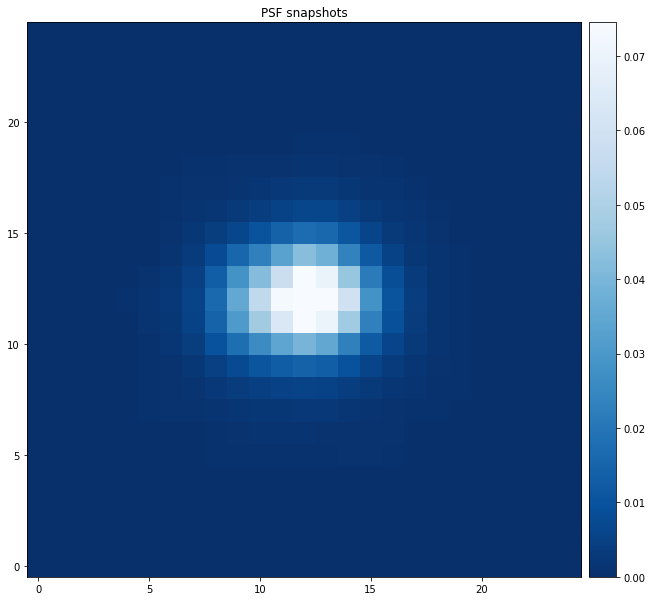

In [5]:
# We do not have enough stars to study PSF spatial variance, so we use order=0 here
psf_model,psf_snapshots = psf.run_psfex(image, mask=mask, checkimages=['SNAPSHOTS'], order=0, verbose=True)

plots.imshow(psf_snapshots)
plt.title('PSF snapshots')

## Injection of simulated stars with given PSF

In [6]:
sims = [] # will hold simulated stars

# We will repeatedly inject the stars, detect objects, and 
# match them in order to see whether simulated stars are detectable

for _ in tqdm(range(100)):
    image1 = image.copy()

    # Simulate 20 random stars 
    sim = pipeline.place_random_stars(image1, psf_model, nstars=20, minflux=10, maxflux=1e6, wcs=wcs, gain=gain, saturation=50000)
    
    sim['mag_calib'] = sim['mag'] + zero_fn(sim['x'], sim['y'])
    sim['detected'] = False
    sim['mag_measured'] = np.nan
    sim['magerr_measured'] = np.nan
    sim['flags_measured'] = np.nan

    mask1 = image1 > 50000
    
    obj1 = photometry.get_objects_sextractor(image1, mask=mask|mask1, r0=1, aper=5.0, wcs=wcs, gain=gain, minarea=3, sn=5)
    obj1['mag_calib'] = obj1['mag'] + zero_fn(obj1['x'], obj1['y'])

    # Positional match within FWHM/2 radius
    h = htm.HTM(10)
    oidx,sidx,dist = h.match(obj1['ra'], obj1['dec'], sim['ra'], sim['dec'], pixscale*np.median(obj1['fwhm'])/2, maxmatch=0)
    # Mark matched stars
    sim['detected'][sidx] = True
    # Also store measured magnitude, its error and flags
    sim['mag_measured'][sidx] = obj1['mag_calib'][oidx]
    sim['magerr_measured'][sidx] = obj1['magerr'][oidx]
    sim['flags_measured'][sidx] = obj1['flags'][oidx]

    sims.append(sim)

#     break
    
from astropy.table import vstack
sims = vstack(sims)

## Diagnostic plots

Text(0, 0.5, 'Measured - Injected')

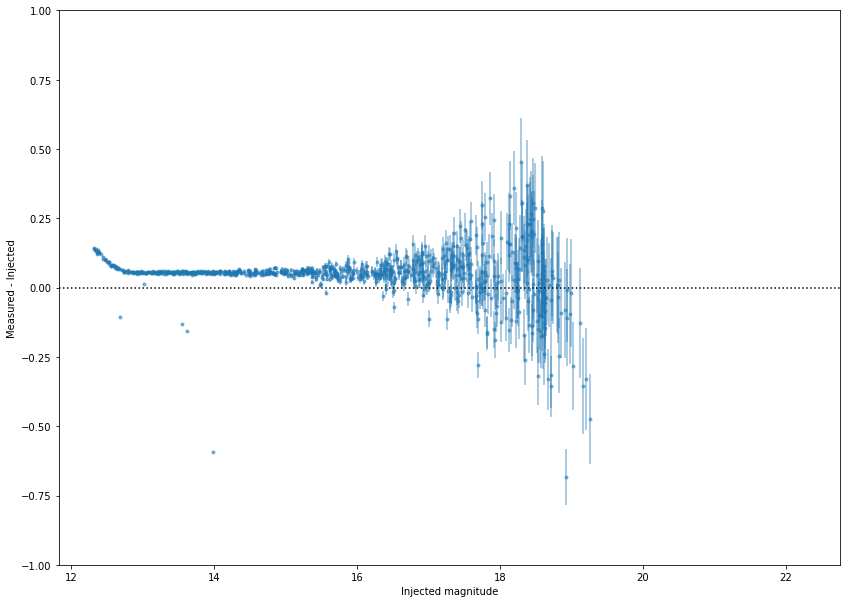

In [7]:
# Only show unflagged detections
idx = sims['detected'] & (sims['flags_measured'] == 0)

plt.errorbar(sims['mag_calib'][idx], (sims['mag_measured'] - sims['mag_calib'])[idx], sims['magerr_measured'][idx], fmt='.', capsize=0, alpha=0.5)

plt.axhline(0, ls=':', color='black')
plt.ylim(-1, 1)

plt.xlabel('Injected magnitude')
plt.ylabel('Measured - Injected')

We clearly see the effect of small aperture we are using for measurement of detected objects - it does not capture all of the flux we are injecting according to the PSF.

The tail towards lower right direction is a variant of Malmquist bias - fainter objects are detectable only when their brightness is (due to Poissonian noise) greater than true value, leading to systematically lower measured magnitudes.

Text(0.5, 0, 'Injected magnitude')

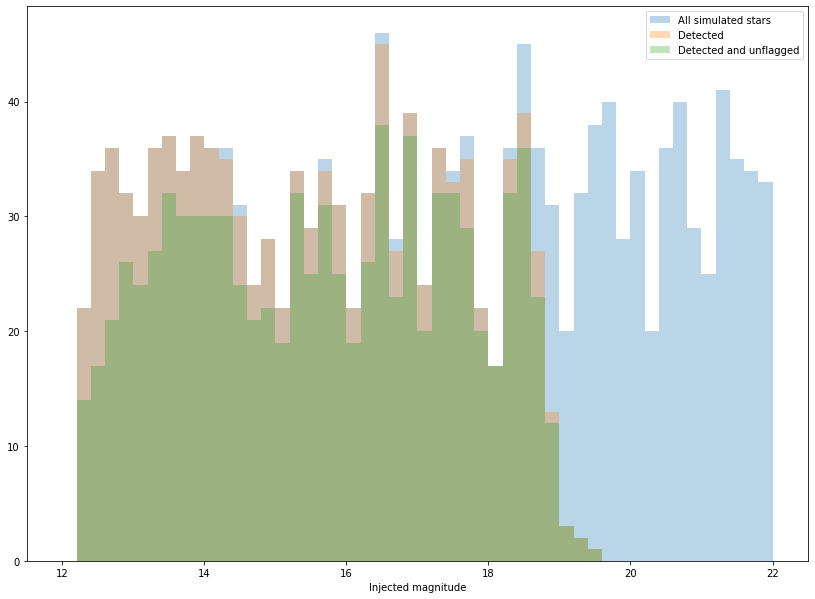

In [8]:
h0,b0,_ = plt.hist(sims['mag_calib'], range=[12,22], bins=50, alpha=0.3, label='All simulated stars');
h1,b1,_ = plt.hist(sims['mag_calib'][sims['detected']], range=[12,22], bins=50, alpha=0.3, label='Detected');
h2,b2,_ = plt.hist(sims['mag_calib'][idx], range=[12,22], bins=50, alpha=0.3, label='Detected and unflagged');

plt.legend()

plt.xlabel('Injected magnitude')

We see that some fraction of simulated stars is always flagged - these are ones blended with objects already present on the frame

<ipython-input-9-c71723e85729>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(0.5*(b0[1:]+b0[:-1]), h1/h0, 'o-', label='Detected')
<ipython-input-9-c71723e85729>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(0.5*(b0[1:]+b0[:-1]), h2/h0, 'o-', label='Detected and unflagged')


Text(0.5, 1.0, 'Fraction of detected artificial stars')

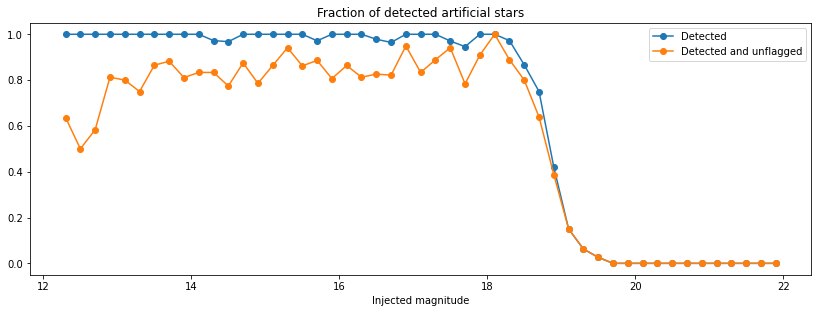

In [9]:
plt.subplot(211)
plt.plot(0.5*(b0[1:]+b0[:-1]), h1/h0, 'o-', label='Detected')
plt.plot(0.5*(b0[1:]+b0[:-1]), h2/h0, 'o-', label='Detected and unflagged')

plt.legend()
plt.xlabel('Injected magnitude')

plt.title('Fraction of detected artificial stars')